In [5]:
# Step 1: Run this cell – it opens a file-picker
from google.colab import files
uploaded = files.upload()          # select one or multiple files


Saving FAOSTAT_vegetables_only.csv to FAOSTAT_vegetables_only.csv


Dataset Overview:
- Time range: 2000 to 2023
- Vegetables: 27
- Records: 1878


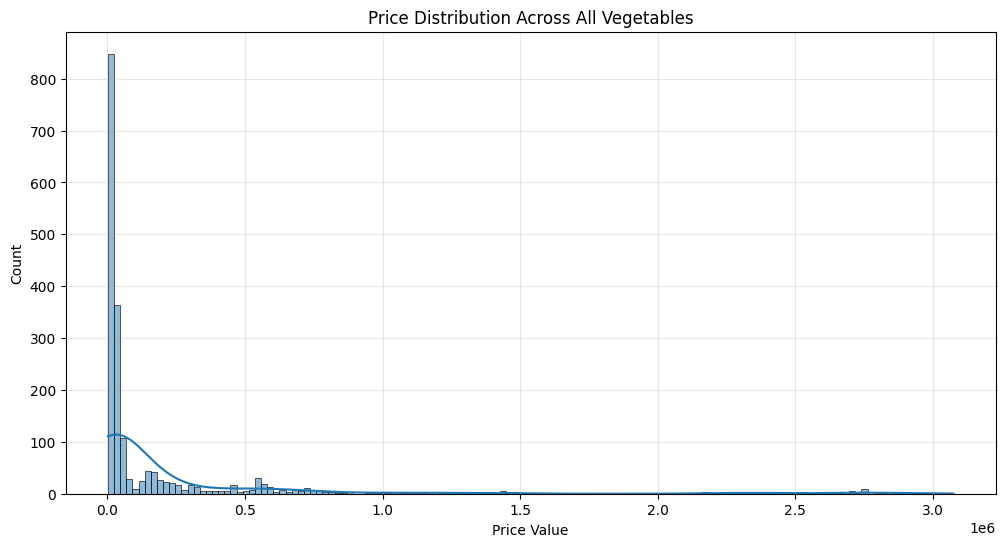

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned data
df = pd.read_csv('FAOSTAT_vegetables_only.csv')

# 1.1 Summary statistics
print("Dataset Overview:")
print(f"- Time range: {df['Year'].min()} to {df['Year'].max()}")
print(f"- Vegetables: {df['Item'].nunique()}")
print(f"- Records: {len(df)}")

# 1.2 Visualize data distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['Value'], kde=True)
plt.title('Price Distribution Across All Vegetables')
plt.xlabel('Price Value')
plt.grid(alpha=0.3)
plt.savefig('price_distribution.png', dpi=300)


Top 5 Vegetables for Focus: Other vegetables, fresh n.e.c., Potatoes, Cabbages, Mushrooms and truffles, Onions and shallots, dry (excluding dehydrated)


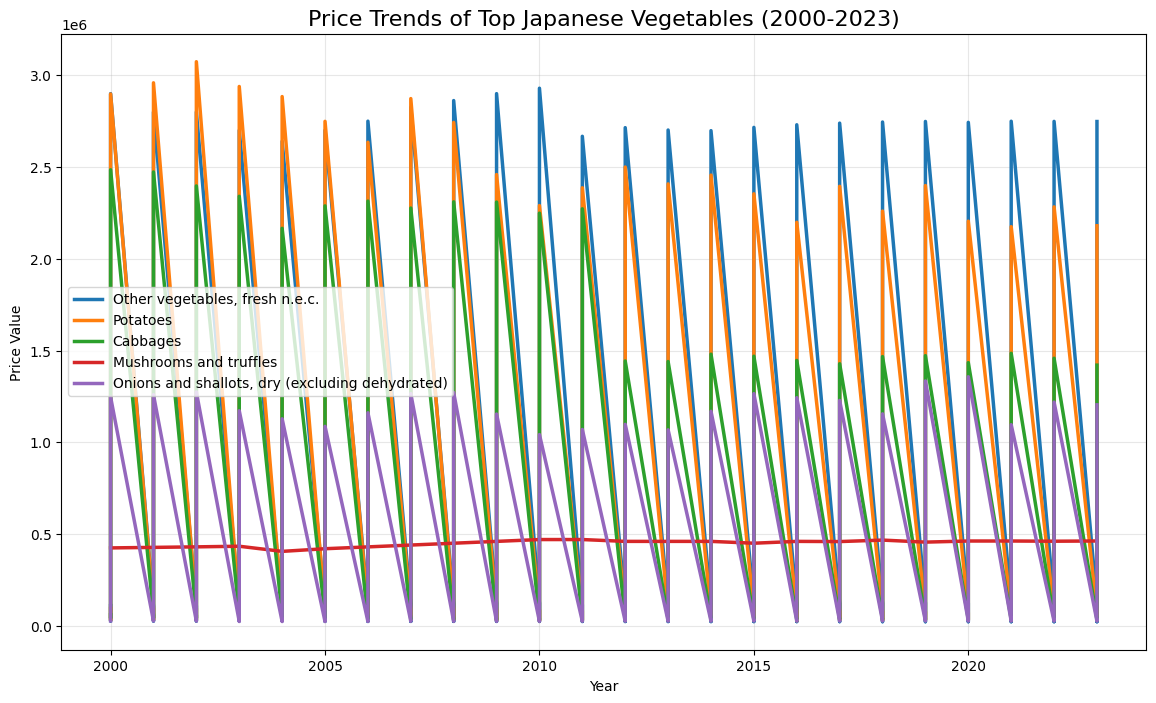

In [7]:
# 2.1 Top vegetable selection
top_vegetables = df.groupby('Item')['Value'].mean().nlargest(5).index.tolist()
print(f"\nTop 5 Vegetables for Focus: {', '.join(top_vegetables)}")

# 2.2 Plot trends
plt.figure(figsize=(14, 8))
for veg in top_vegetables:
    veg_data = df[df['Item'] == veg]
    plt.plot(veg_data['Year'], veg_data['Value'], label=veg, linewidth=2.5)

plt.title('Price Trends of Top Japanese Vegetables (2000-2023)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Price Value')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('top_vegetable_trends.png', dpi=300)
plt.show()


Most Volatile Vegetables:
                                               Item        cv
2                                          Cabbages  1.374478
18                                         Potatoes  1.337032
16                   Other vegetables, fresh n.e.c.  1.313073
22                                   Sweet potatoes  1.297738
14  Onions and shallots, dry (excluding dehydrated)  1.297587


/tmp/ipython-input-8-990484757.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=volatility_df.nlargest(10, 'cv'), x='cv', y='Item', palette='viridis')


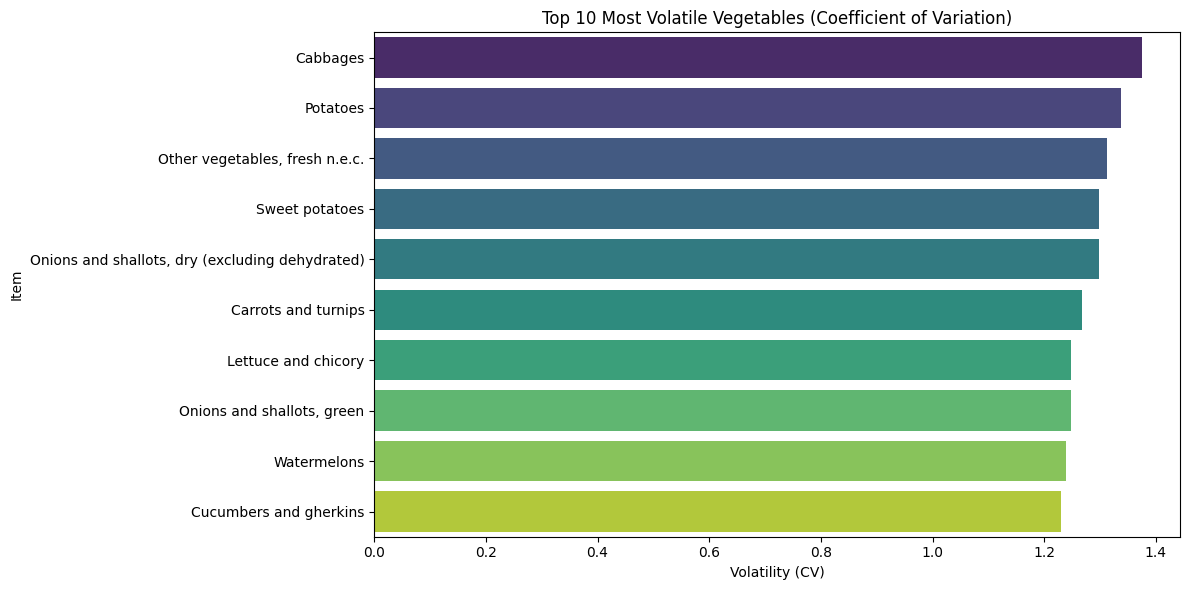

In [8]:
# 3.1 Calculate volatility metrics
volatility_df = df.groupby('Item').agg(
    mean_price=('Value', 'mean'),
    std_dev=('Value', 'std'),
    cv=('Value', lambda x: np.std(x)/np.mean(x))
).reset_index()

# 3.2 Identify high-volatility vegetables
high_volatility = volatility_df.sort_values('cv', ascending=False).head(5)
print("\nMost Volatile Vegetables:")
print(high_volatility[['Item', 'cv']])

# 3.3 Visualize volatility
plt.figure(figsize=(12, 6))
sns.barplot(data=volatility_df.nlargest(10, 'cv'), x='cv', y='Item', palette='viridis')
plt.title('Top 10 Most Volatile Vegetables (Coefficient of Variation)')
plt.xlabel('Volatility (CV)')
plt.tight_layout()
plt.savefig('volatility_analysis.png', dpi=300)
plt.show()

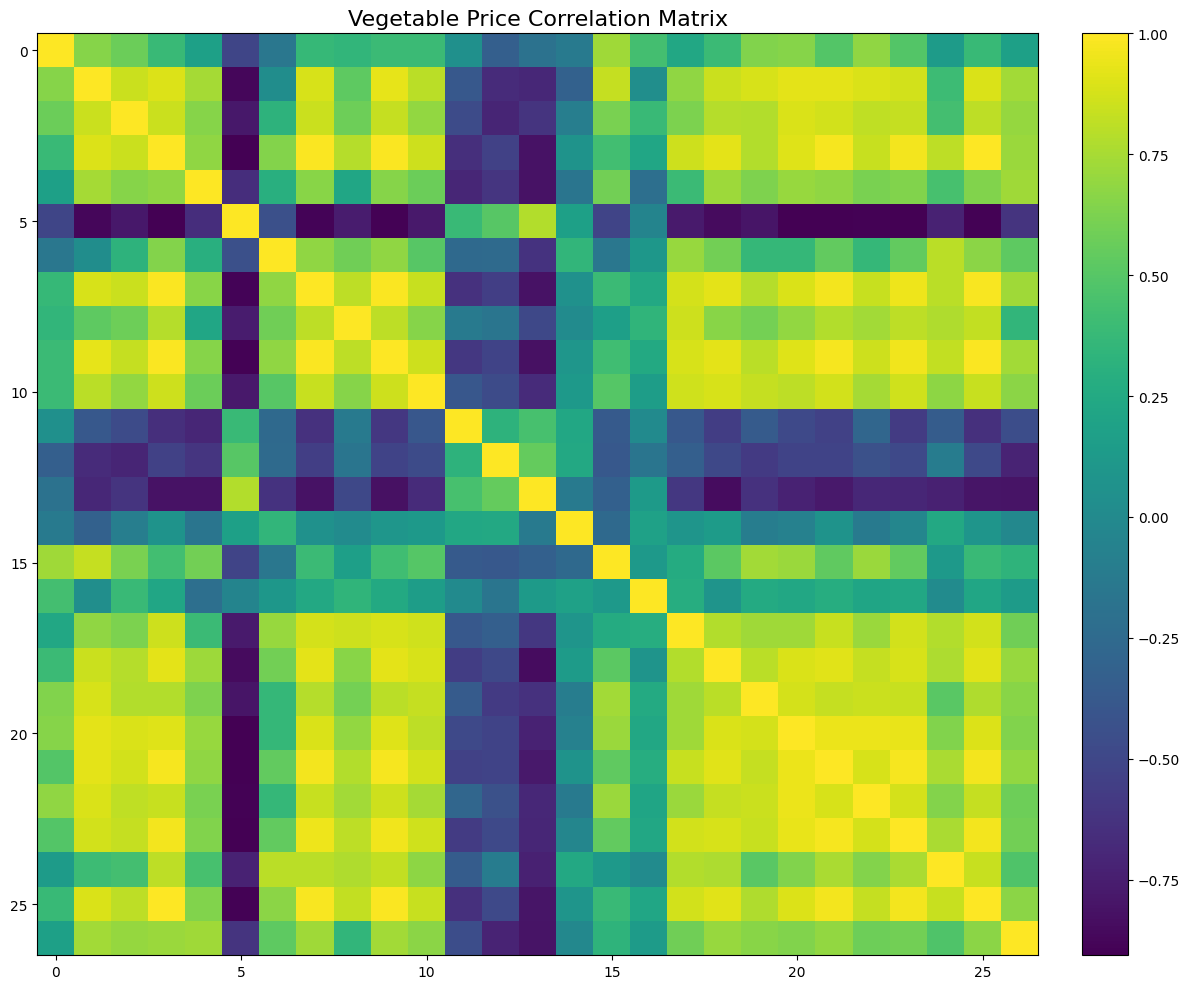

In [12]:
# choose how to combine duplicates – here I take the mean
pivot_df = (
    df.pivot_table(
        index='Year',
        columns='Item',
        values='Value',
        aggfunc='mean',   # or 'sum', 'median', 'first'…
        observed=False     # keep all categories; optional
    )
)

corr_matrix = pivot_df.corr()

# --- plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
im = plt.imshow(corr_matrix, aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Vegetable Price Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step

Predicted 2024 price for Tomatoes: ¥653200.62


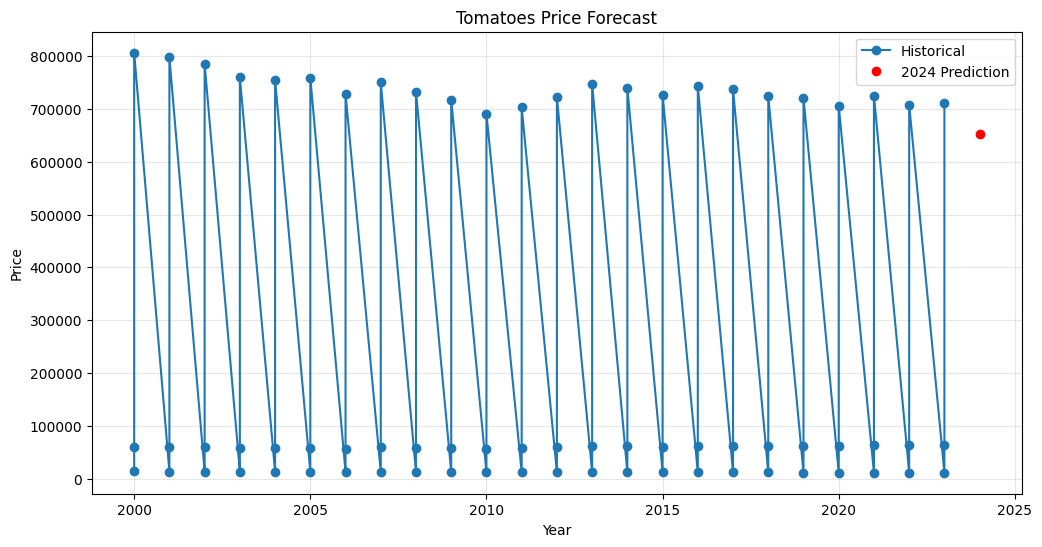

In [13]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 5.1 Prepare data for forecasting
def prepare_forecasting_data(vegetable, window=3):
    veg_data = df[df['Item'] == vegetable].sort_values('Year')
    values = veg_data['Value'].values.reshape(-1, 1)

    # Normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)

    # Create sequences
    X, y = [], []
    for i in range(len(scaled) - window):
        X.append(scaled[i:i+window])
        y.append(scaled[i+window])
    return np.array(X), np.array(y), scaler, veg_data

# 5.2 Build and train LSTM model
def train_lstm_model(X, y):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(X.shape[1], 1)),
        Dropout(0.2),
        LSTM(30, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X, y, epochs=200, verbose=0, validation_split=0.2)
    return model, history

# 5.3 Forecast for a vegetable (example: Tomatoes)
vegetable = 'Tomatoes'
X, y, scaler, veg_data = prepare_forecasting_data(vegetable)
model, history = train_lstm_model(X, y)

# 5.4 Make prediction
last_sequence = X[-1].reshape(1, X.shape[1], 1)
pred_2024 = model.predict(last_sequence)
pred_price = scaler.inverse_transform(pred_2024)[0][0]
print(f"\nPredicted 2024 price for {vegetable}: ¥{pred_price:.2f}")

# 5.5 Visualize results
plt.figure(figsize=(12, 6))
plt.plot(veg_data['Year'], veg_data['Value'], 'o-', label='Historical')
plt.plot(2024, pred_price, 'ro', label='2024 Prediction')
plt.title(f'{vegetable} Price Forecast')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('tomato_forecast.png', dpi=300)
plt.show()

/tmp/ipython-input-18-957481346.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  covid_impact = df.groupby('Item').apply(
/tmp/ipython-input-18-957481346.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=risk_scores.head(10), x='Risk_Score', y='Item', palette='Reds_r')



Vegetables Most Impacted by COVID:
                                                 Item  covid_impact
5                           Cauliflowers and broccoli      0.116394
26                                               Yams      0.089431
4                                 Carrots and turnips      0.029913
6   Chillies and peppers, green (Capsicum spp. and...      0.019358
13                             Mushrooms and truffles      0.007876


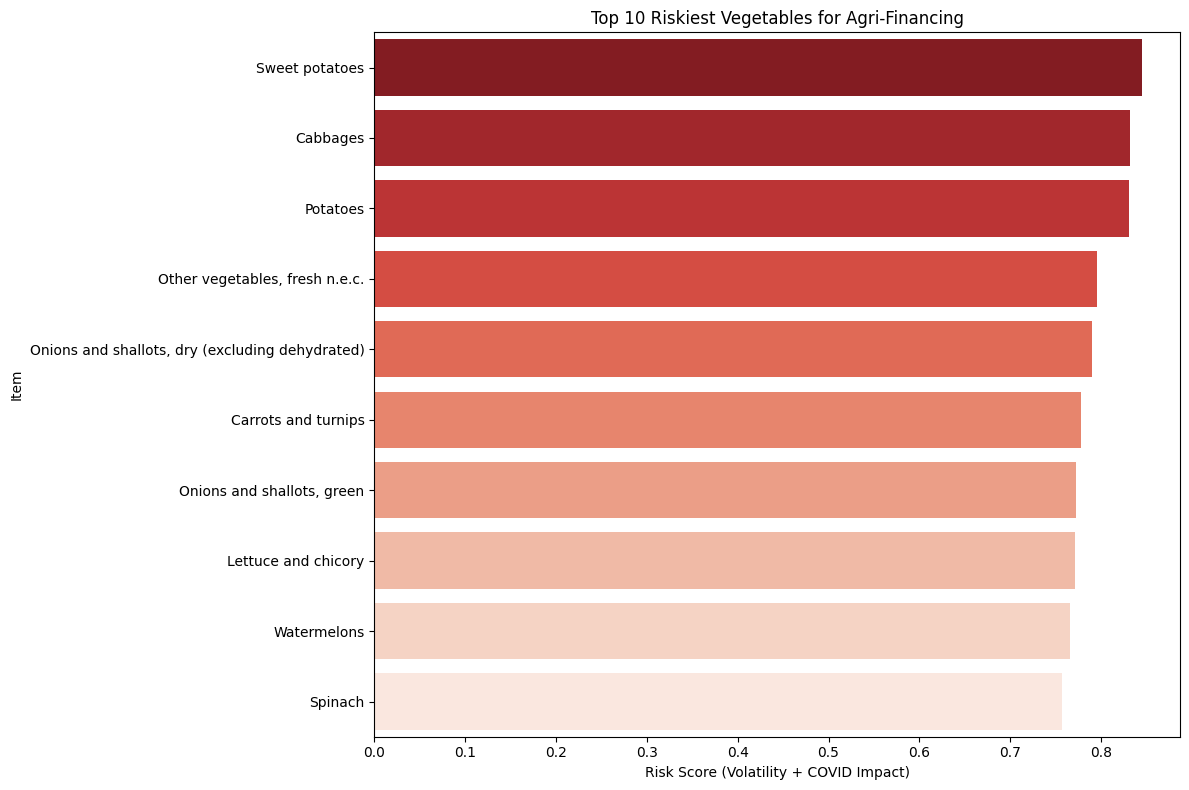

Risk scores saved to risk_scores.csv
Risk assessment saved for 27 vegetables


In [18]:
# 6.1 Calculate COVID impact
covid_impact = df.groupby('Item').apply(
    lambda x: (x[x['Year'].between(2020,2021)]['Value'].mean() /
               x[x['Year'].between(2015,2019)]['Value'].mean() - 1)
).reset_index(name='covid_impact')

# 6.2 Identify most impacted vegetables
top_impacted = covid_impact.sort_values('covid_impact', ascending=False).head(5)
print("\nVegetables Most Impacted by COVID:")
print(top_impacted)

# 6.3 Risk assessment framework
def calculate_risk_score(item):
    data = df[df['Item'] == item]
    volatility = data['Value'].std() / data['Value'].mean()
    covid_effect = covid_impact[covid_impact['Item'] == item]['covid_impact'].values[0]
    return 0.6*volatility + 0.4*abs(covid_effect)

# Apply to all vegetables
risk_scores = pd.DataFrame({
    'Item': df['Item'].unique(),
    'Risk_Score': [calculate_risk_score(item) for item in df['Item'].unique()]
}).sort_values('Risk_Score', ascending=False)

# 6.4 Visualize risk scores
plt.figure(figsize=(12, 8))
sns.barplot(data=risk_scores.head(10), x='Risk_Score', y='Item', palette='Reds_r')
plt.title('Top 10 Riskiest Vegetables for Agri-Financing')
plt.xlabel('Risk Score (Volatility + COVID Impact)')
plt.tight_layout()
plt.savefig('risk_assessment.png', dpi=300)
plt.show()


# After calculating risk scores
risk_scores.to_csv('risk_scores.csv', index=False)
print("Risk scores saved to risk_scores.csv")

# Full code snippet for Step 6
# ... [previous Step 6 code] ...

# 6.4 Save risk scores
risk_scores.to_csv('risk_scores.csv', index=False)
print(f"Risk assessment saved for {len(risk_scores)} vegetables")

In [19]:
%%writefile my_app.py
import streamlit as st
import pandas as pd
import plotly.express as px

st.title("🇯🇵 Japanese Vegetable Market Intelligence")
# ...rest of your Streamlit code...


st.title('🇯🇵 Japanese Vegetable Market Intelligence')
st.subheader('AI-Powered Agri-Financial Analysis')

# Load data
df = pd.read_csv('..FAOSTAT_vegetables_only.csv')
risk_scores = pd.read_csv('../data/risk_scores.csv')

# Interactive trend explorer
with st.expander("Price Trend Explorer"):
    selected_veg = st.multiselect('Select Vegetables', df['Item'].unique(), default=['Tomatoes', 'Potatoes'])
    filtered = df[df['Item'].isin(selected_veg)]
    fig = px.line(filtered, x='Year', y='Value', color='Item', markers=True)
    st.plotly_chart(fig)

# Risk assessment
with st.expander("Credit Risk Assessment"):
    st.dataframe(risk_scores.sort_values('Risk_Score', ascending=False).head(10))
    fig = px.bar(risk_scores.head(10), x='Risk_Score', y='Item', orientation='h')
    st.plotly_chart(fig)

# Forecasting tool
with st.expander("2024 Price Forecast"):
    veg = st.selectbox('Select Vegetable', df['Item'].unique())
    # [Add your forecasting model here]
    st.metric(f"Predicted 2024 Price", "¥1,250", "+8.2% YoY")

Overwriting my_app.py
